# Import Packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer

import mlflow

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

from sklearn.metrics import ConfusionMatrixDisplay
from mlflow.sklearn import autolog

# Load the Data

In [3]:
# read the csv file

df = pd.read_csv("data/titanic.csv")

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# check for missing values in data

(
    df
    .isna()
    .sum()
)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Observations**:
1. `Age`, `Emabrked` and `Cabin` columns have missing values.

In [9]:
# info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Data CLeaning

In [12]:
# columns to drop

columns_to_drop = ['passengerid','name','ticket','cabin']

In [14]:
def clean_data(df):
    return (
        df
        .rename(columns=str.lower)
        .drop(columns=columns_to_drop)
        .assign(
            family = lambda df_ : df_['sibsp'] + df_['parch']
        )
        .drop(columns=['sibsp','parch'])
    )

In [16]:
final_df = clean_data(df)

final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [18]:
# shape of the cleaned data 

print(f'The cleaned data has {final_df.shape[0]} rows and {final_df.shape[1]} columns')

The cleaned data has 891 rows and 7 columns


In [20]:
# missing values in the cleaned data

(
    final_df
    .isna()
    .sum()
)

survived      0
pclass        0
sex           0
age         177
fare          0
embarked      2
family        0
dtype: int64

# EDA

In [23]:
# distribution of target

(
    final_df
    .loc[:,'survived']
    .value_counts(normalize=True)
)

survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [25]:
# boxplots

def create_boxplot(data,column_name,hue=None):
    sns.boxplot(data=data, y=column_name, hue=hue)

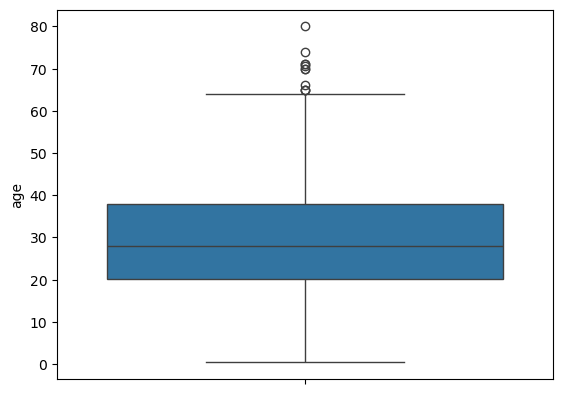

In [27]:
# boxplot for age column
create_boxplot(final_df,'age')

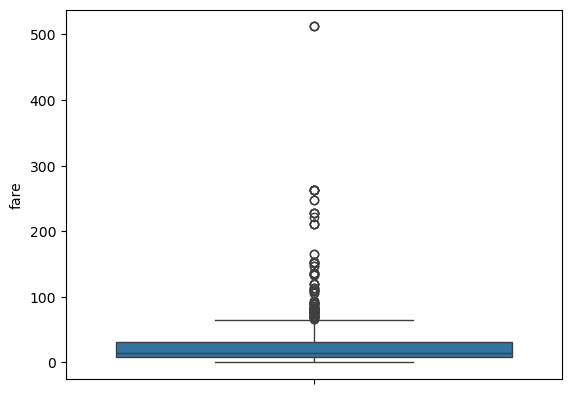

In [29]:
# boxplot for fare column

create_boxplot(final_df,'fare')

**Overview**
- Outliers in the age and fare columns

In [32]:
# plot the distribution of categorical columns

def plot_distribution(data,column_name):
    sns.countplot(data=data, x=column_name)

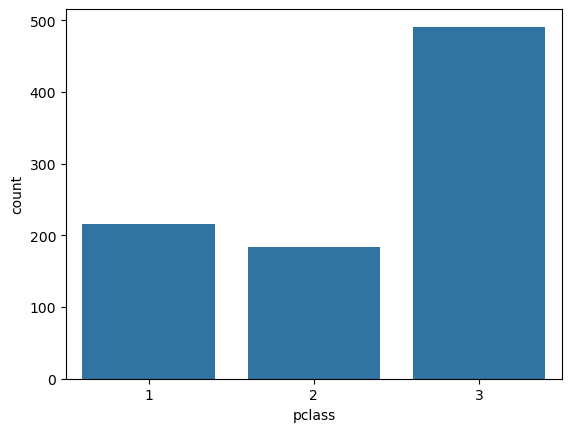

In [34]:
# distribution for pclass
plot_distribution(final_df,'pclass')

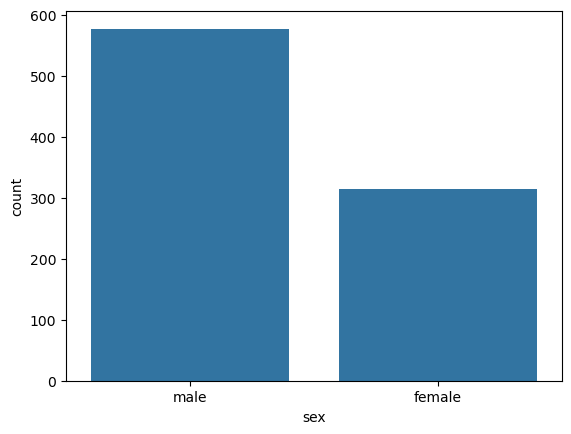

In [36]:
# distribution for sex

plot_distribution(final_df,'sex')

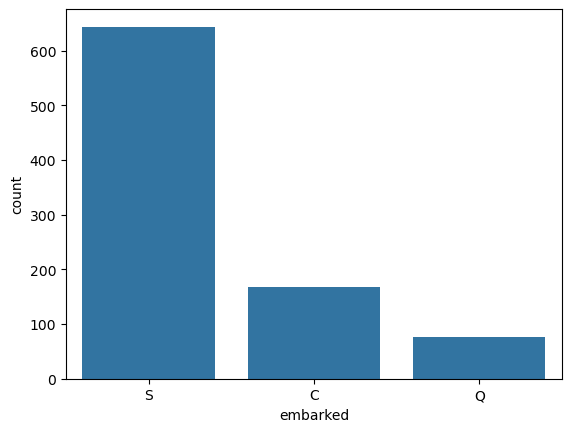

In [38]:
# distribution for embarked 

plot_distribution(final_df,'embarked')

# Feature_Eng

In [41]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [43]:
# make X and y

X = final_df.drop(columns=['survived'])
y = final_df['survived']

In [45]:
X.head()

,pclass,sex,age,fare,embarked,family
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [47]:
# do train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print('The shape of training data is',X_train.shape)
print('The shape of testing data is',X_test.shape)

The shape of training data is (712, 6)
The shape of testing data is (179, 6)


## Pipelines for Individual Columns

In [50]:
# age_pipeline
age_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')),
    ('outliers',Winsorizer(capping_method='gaussian',fold=3)),
    ('scale',StandardScaler())
])


age_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())])

In [52]:
# fare pipeline

fare_pipe = Pipeline(steps=[
    ('outliers',Winsorizer(capping_method='iqr',fold=1.5)),
    ('scale',StandardScaler())
])

fare_pipe

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [54]:
# embarked_pipeline

embarked_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('count_encode',CountFrequencyEncoder(encoding_method='count')),
    ('scale',MinMaxScaler())
])

embarked_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

## Column Transformer

In [57]:
set_config(transform_output='pandas')

In [59]:
# make column column transformer

preprocessor = ColumnTransformer(transformers=[
    ('age',age_pipe,['age']),
    ('fare',fare_pipe,['fare']),
    ('embarked',embarked_pipe,['embarked']),
    ('sex',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['sex']),
    ('family',MinMaxScaler(),['family'])
],remainder='passthrough',n_jobs=-1)

preprocessor

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('outliers',
                                                  Winsorizer(fold=3)),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('outliers',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('count_encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [61]:
# fit and transform the training data

preprocessor.fit_transform(X_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass
331,1.266850,0.236751,1.0,0.0,1.0,0.0,1
733,-0.478777,-0.532339,1.0,0.0,1.0,0.0,2
382,0.219474,-0.784153,1.0,0.0,1.0,0.0,3
704,-0.246027,-0.787666,1.0,0.0,1.0,0.1,3
813,-1.797695,0.374443,1.0,1.0,0.0,0.6,3
...,...,...,...,...,...,...,...
106,-0.633944,-0.797799,1.0,1.0,0.0,0.0,3
270,-0.090860,0.360798,1.0,0.0,1.0,0.0,1
860,0.917724,-0.477346,1.0,0.0,1.0,0.2,3
435,-1.177028,2.016201,1.0,1.0,0.0,0.3,1


In [62]:
preprocessor.get_params()

{'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                 ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
 'fare':

# Model Pipeline

In [66]:
# build the model pipeline

model_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

In [68]:
model_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('clf',RandomForestClassifier())
])

model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['fare']),
                                                 ('embarked',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf', RandomForestClassifier())])

# MLFlow Tracking code

## Grid Search

In [86]:
# set the uri for server

mlflow.set_tracking_uri("http://127.0.0.1:8080")

mlflow.set_experiment("Grid Search")

mlflow.sklearn.autolog()

params_grid = {
    "clf__n_estimators": list(range(100,300,100)),
    "clf__max_depth": [2,3,4,5,6,7]
}

with mlflow.start_run(run_name='outer',nested=True) as parent:
    # grid search object
    grid_search = GridSearchCV(estimator=model_pipe,
                               cv=3,
                               param_grid=params_grid,
                               scoring='f1',
                               n_jobs=-1)
    # fit the grid search
    grid_search.fit(X_train,y_train)

with mlflow.start_run(run_name='best_model') as best:
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("f1",grid_search.best_score_)
    mlflow.sklearn.log_model(sk_model=grid_search.best_estimator_,
                            artifact_path='best_model',
                            registered_model_name='Titanic_Random_Forest')


2024/07/28 16:26:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\vedan\anaconda3\Lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/28 16:26:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\vedan\anaconda3\Lib\site-packages\mlflow\types

## Hyperopt

In [74]:
!pip install hyperopt

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.6 MB 812.7 kB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.6 MB 2.0 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.6 MB 2.7 MB/s eta 0:00:01
   ----------------- ---------------------- 0.7/1.6 MB 3.3 MB/s eta 0:00:01
   ---------------------- ----------------- 0.9/1.6 MB 3.3 MB/s eta 0:00:01
   ---------------------------- ----------- 1.1/1.6 MB 3.8 MB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.6 MB 3.6 MB/s eta 0:00:01
   ----------------------------------- ---- 1.4/1.6 MB 3.6 MB/s eta 0:00:01
   -------------------------------------- - 1.5/1.6 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/200.5 kB ? eta -:--:--
   ---------------- ---------

In [70]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [72]:
# define the search space

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 10),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'criterion': hp.choice('criterion',['gini','entropy'])
}

In [76]:
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        n_estimators = int(params['n_estimators'])
        max_depth = int(params['max_depth'])

        model_pipe.named_steps['clf'].set_params(
            n_estimators=n_estimators, max_depth=max_depth
        )
        model_pipe.fit(X_train, y_train)

        y_pred = model_pipe.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)  # Calculate F1 score

        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)  # Log F1 score

    return {"loss": -accuracy, "f1_score": f1, "status": STATUS_OK}


In [78]:
# set the tracking uri

mlflow.set_tracking_uri("http://127.0.0.1:8080")

mlflow.set_experiment("HP Tuning Hyperopt")

with mlflow.start_run(nested=True):
    # set the fmin function
    trials = Trials()
    
    best = fmin(fn=objective, 
                space=space, 
                algo=tpe.suggest, 
                max_evals=50, 
                trials=trials,)

100%|██████████| 50/50 [00:15<00:00,  3.27trial/s, best loss: -0.8435754189944135]
